In [1]:
#loading necessary libraries
from skimage import io
import skimage
import skimage.transform
from skimage import feature

from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [2]:
# image loading
image2 = io.imread('lena_color.gif')

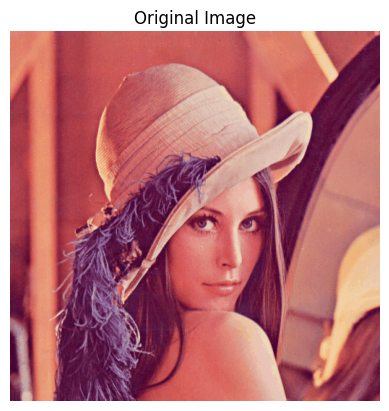

In [4]:
# image display
plt.imshow(image2[0]) 
plt.title('Original Image')
plt.axis('off');

In [5]:
# conversion of image to grayscale format
def rgb_gray(rgb):
    if len(rgb.shape) == 2:
        # If the image is already in grayscale, just return it
        return rgb
    elif len(rgb.shape) == 3 and rgb.shape[2] == 3:
        # If the image is in RGB format, convert it to grayscale
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray
    else:
        raise ValueError("Error")

In [7]:
image2 = rgb_gray(image2[0])

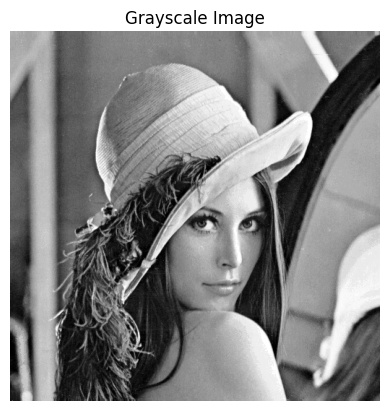

In [8]:
# display grayscale image
plt.imshow(image2, 'gray') 
plt.title('Grayscale Image')
plt.axis('off');

### 1. Gaussian Filtering

Due to the noise that may appear in the image (and potentially disrupt the detection of only significant edges), it is first necessary to apply filtering.

In [9]:
def gauss(image_in, std):
    # Determine the size of the window
    n = int(np.ceil(6*std))  # first number greater than or equal to 6*std
    if n % 2 == 0:           # if it is even
        n += 1               # add 1

    # Form the filtering window
    mask = np.zeros((n, n))

    # Fill the mask
    for i in range(n):
        for j in range(n):
            mask[i, j] = np.exp(-((i - n // 2) ** 2 + (j - n // 2) ** 2) / (2 * std ** 2))

    # Normalize
    mask = mask / np.sum(mask)

    # Gaussian filtering using convolution
    gauss_image = cv2.filter2D(image_in, -1, mask)

    return gauss_image

In [10]:
image_gauss = gauss(image2, 2)  # Gaussian filtering with std=2

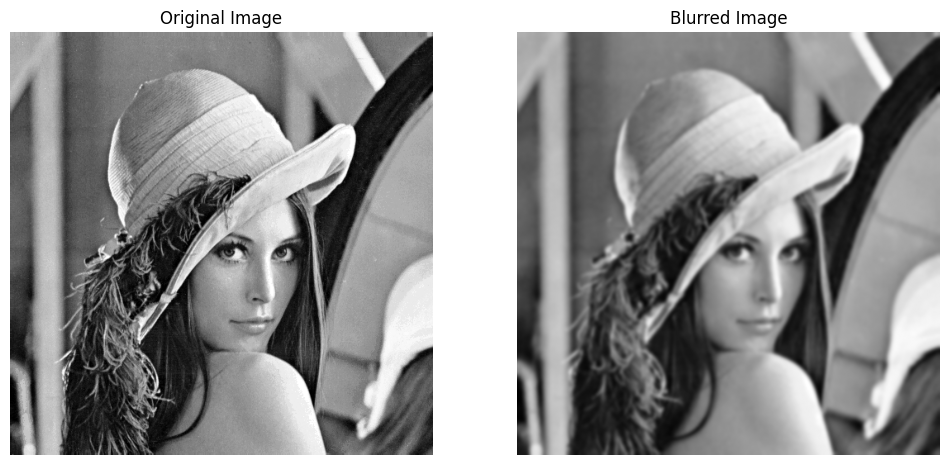

In [11]:
# Display the original and blurred images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(image2, 'gray')
plt.title('Original Image')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(image_gauss, 'gray')
plt.title('Blurred Image')
plt.axis('off');

### 2. Determining the Horizontal and Vertical Gradients of the Filtered Image

Next, it is necessary to find the rate of change of pixel intensity in the horizontal and vertical directions. This step is characteristic for edge detection because it is at the edges where there is a sudden change in intensity (the derivative will be large). Sobel operators were used for this step.

In [12]:
def gradients(image_in):
    # forming kernels for Sobel operators
    hy = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    hx = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
    
    # forming empty kernels of the size of the original image
    gradient_x = np.zeros(image_in.shape)
    gradient_y = np.zeros(image_in.shape)
    
    # convolution of the image with the operators
    for i in range(1, image_in.shape[0]-1):
        for j in range(1, image_in.shape[1]-1):
            gradient_x[i, j] = np.sum(np.multiply(hx, image_in[i-1:i+2, j-1:j+2]))
            gradient_y[i, j] = np.sum(np.multiply(hy, image_in[i-1:i+2, j-1:j+2]))
    
    return gradient_x, gradient_y

In [13]:
grad_x, grad_y = gradients(image_gauss)

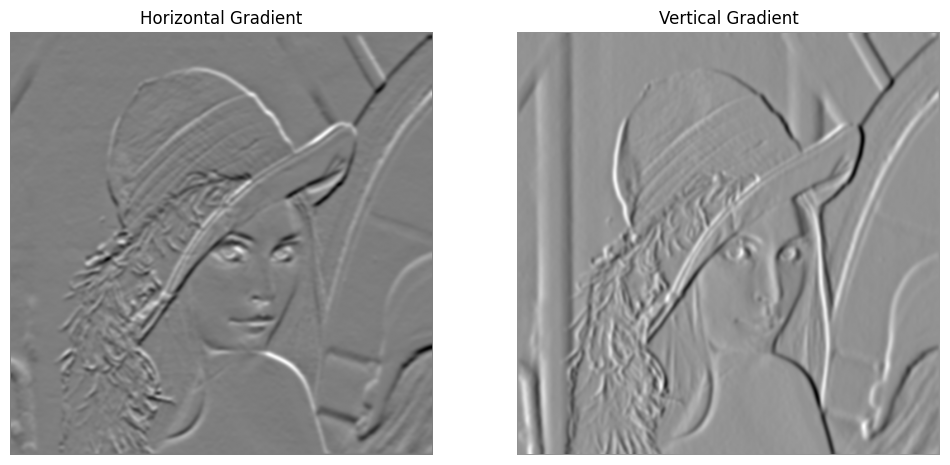

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(grad_x, 'gray')
plt.title('Horizontal Gradient')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(grad_y, 'gray')
plt.title('Vertical Gradient')
plt.axis('off');

### 3. Determining the Magnitude and Angle of the Gradient

By combining horizontal and vertical gradients, it is possible to obtain the overall gradient at each pixel - the magnitude, as well as its direction - the angle.

In [15]:
def mag_thet(gradient_x, gradient_y):
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)  # determining magnitude
    theta = np.arctan2(gradient_x, gradient_y)          # determining angle

    return magnitude, theta

In [16]:
magnitude, theta = mag_thet(grad_y, grad_x)

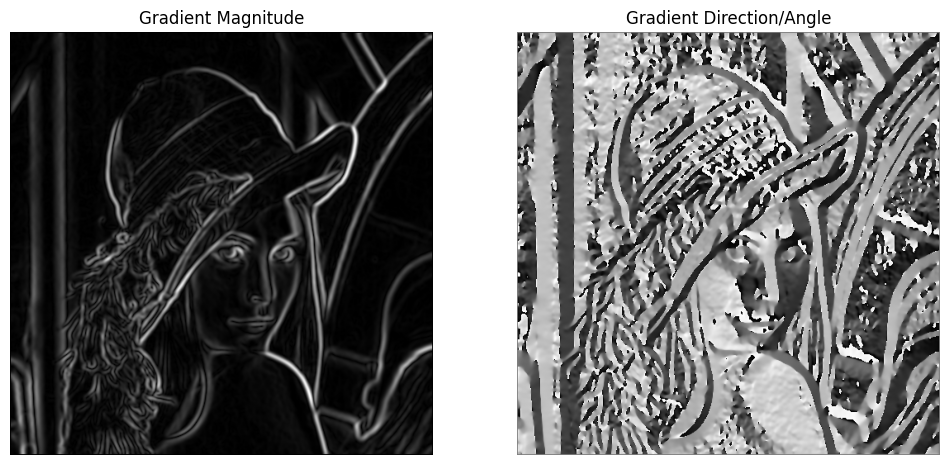

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, 'gray')
plt.title('Gradient Magnitude')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(theta, 'gray')
plt.title('Gradient Direction/Angle')
plt.axis('off');

### 4. Quantization of the Gradient to One of 4 Directions (-45°, 0°, 45°, and 90°)

To reduce the number of possible gradient directions, quantization is applied. This step is useful for speeding up the program, reducing dimensionality, and being resistant to small fluctuations in gradient angle values (noise).

In [18]:
def quant(theta):
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            # if the angle is in the range from -22.5 to 22.5 or from 157.5 to 180, set it to 0
            if (theta[i,j] < 22.5*np.pi/180 and theta[i,j] > -22.5*np.pi/180) or (theta[i,j] > 157.5*np.pi/180) or (theta[i,j] < -157.5*np.pi/180):
                theta[i,j] = 0
            # if the angle is in the range from 22.5 to 67.5 or from -112.5 to -157.5, set it to 45
            elif (theta[i,j] > 22.5*np.pi/180 and theta[i,j] < 67.5*np.pi/180) or (theta[i,j] < -112.5*np.pi/180 and theta[i,j] > -157.5*np.pi/180):
                theta[i,j] = np.pi/4
            # if the angle is in the range from 67.5 to 112.5 or from -67.5 to -112.5, set it to 90
            elif (theta[i,j] > 67.5*np.pi/180 and theta[i,j] < 112.5*np.pi/180) or (theta[i,j] < -67.5*np.pi/180 and theta[i,j] > -112.5*np.pi/180):
                theta[i,j] = np.pi/2
            # if the angle is in the range from 112.5 to 157.5 or from -22.5 to -67.5, set it to -45
            elif (theta[i,j] > 112.5*np.pi/180 and theta[i,j] < 157.5*np.pi/180) or (theta[i,j] < -22.5*np.pi/180 and theta[i,j] > -67.5*np.pi/180):
                theta[i,j] = -np.pi/4
                
    return theta

In [19]:
theta = quant(theta)

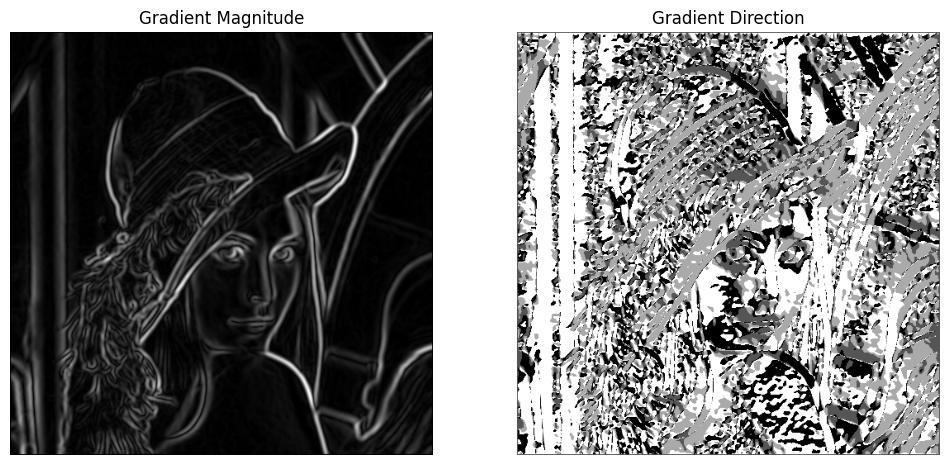

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, 'gray')
plt.title('Gradient Magnitude')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(theta, 'gray')
plt.title('Gradient Direction')
plt.axis('off');

### 5. Suppression of Gradient Values That Do Not Represent Local Maxima

Non-maximum suppression is used to reduce the thickness of the detected edge to 1.

In [21]:
def supression(magnitude, angle):
    magnitude1 = np.copy(magnitude)
    for i in range(1, magnitude.shape[0]-1):
        for j in range(1, magnitude.shape[1]-1):
            if angle[i, j] == 0:
                # if the current pixel is greater than the neighboring pixels in the direction normal to the gradient, keep it, otherwise set it to 0
                if not (magnitude[i, j] > magnitude[i-1, j] and magnitude[i, j] > magnitude[i+1, j]):
                    magnitude1[i, j] = 0
            if angle[i, j] == np.pi/4:
                # if the current pixel is greater than the neighboring pixels in the direction normal to the gradient, keep it, otherwise set it to 0
                if not (magnitude[i, j] > magnitude[i-1, j-1] and magnitude[i, j] > magnitude[i+1, j+1]):
                    magnitude1[i, j] = 0
            if angle[i, j] == np.pi/2:
                # if the current pixel is greater than the neighboring pixels in the direction normal to the gradient, keep it, otherwise set it to 0
                if not (magnitude[i, j] > magnitude[i, j-1] and magnitude[i, j] > magnitude[i, j+1]):
                    magnitude1[i, j] = 0
            if angle[i, j] == -np.pi/4:
                # if the current pixel is greater than the neighboring pixels in the direction normal to the gradient, keep it, otherwise set it to 0
                if not (magnitude[i, j] > magnitude[i-1, j+1] and magnitude[i, j] > magnitude[i+1, j-1]):
                    magnitude1[i, j] = 0

    return magnitude1

In [22]:
magnitude = supression(magnitude, theta)

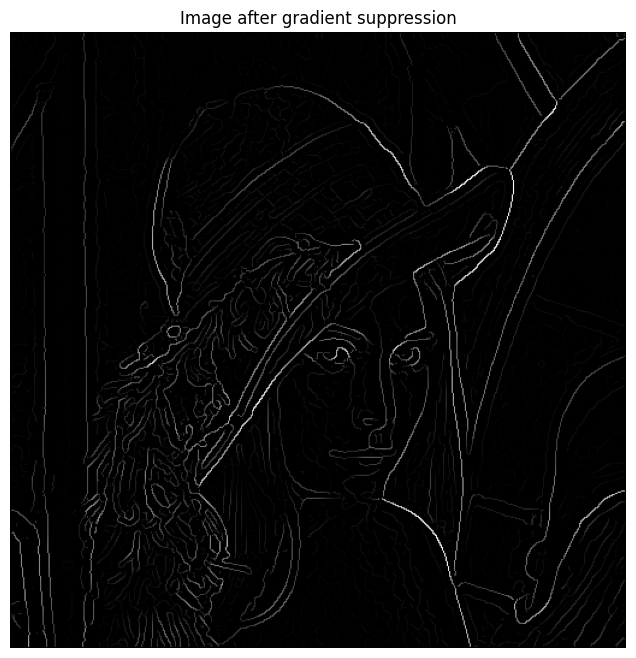

In [23]:
plt.figure(figsize=(12,8))
plt.imshow(magnitude, 'gray')
plt.title('Image after gradient suppression')
plt.axis('off');

### 6. Determining Maps of Strong and Weak Edges

Using the upper and lower thresholds, strong (all those with a value above the upper threshold) and weak (those with a value between the lower and upper thresholds) edges are determined.

In [24]:
def strong_weak_edges(magnitude, up, down):
    # initialization of thresholds
    strong_edges = np.zeros(magnitude.shape)
    weak_edges = np.zeros(magnitude.shape)
    for i in range(magnitude.shape[0]):
        for j in range(magnitude.shape[1]):
            if magnitude[i, j] > up:     # if the pixel is stronger than the upper threshold, set it in strong_edges
                strong_edges[i, j] = 1
            elif magnitude[i, j] > down: # if the pixel is stronger than the lower threshold, set it in weak_edges
                weak_edges[i, j] = 1

    return strong_edges, weak_edges

In [25]:
strong_edges, weak_edges = strong_weak_edges(magnitude, 50, 10)

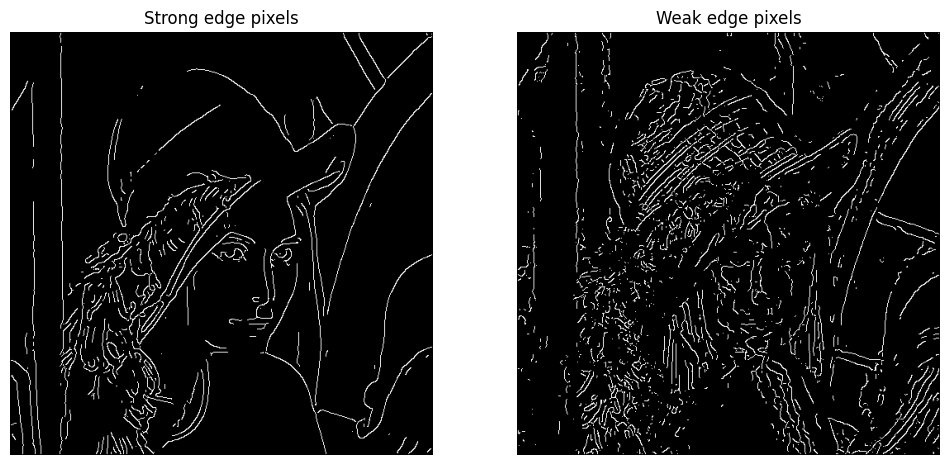

In [26]:
# display strong and weak edges at the beginning
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(strong_edges, 'gray')
plt.title('Strong edge pixels')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(weak_edges, 'gray')
plt.title('Weak edge pixels')
plt.axis('off');

### 7. Inclusion of Weaker Edges

The obtained maps need to be used to get the final edge map. The procedure followed converts weak pixels (which belong to edges) to strong ones if the weak pixel touches at least one strong pixel. Convergence is reached when the final mask does not change in two consecutive steps.

In [27]:
def inclusion(strong_edges, weak_edges):
    # if a weak edge is connected to a strong edge, include it
    while True:
        weak_edges1 = weak_edges.copy()
        for i in range(1, strong_edges.shape[0]-1):
            for j in range(1, strong_edges.shape[1]-1):
                if weak_edges[i,j] != 0:    # if the current pixel is a weak edge pixel
                    # if any of the neighboring pixels is a strong edge pixel, include the current pixel
                    if strong_edges[i-1,j-1] != 0 or strong_edges[i-1,j] != 0 or strong_edges[i-1,j+1] != 0 or strong_edges[i,j-1] != 0 or strong_edges[i,j+1] != 0 or strong_edges[i+1,j-1] != 0 or strong_edges[i+1,j] != 0 or strong_edges[i+1,j+1] != 0:
                        strong_edges[i,j] = weak_edges1[i,j]
                        weak_edges1[i,j] = 0
        if sum(sum(weak_edges1 == weak_edges)) == weak_edges.shape[0]*weak_edges.shape[1]:  # if nothing has changed, break the loop
            break
        else:
            weak_edges = weak_edges1.copy()
    
    return strong_edges, weak_edges

In [28]:
strong_edges, weak_edges = inclusion(strong_edges, weak_edges)

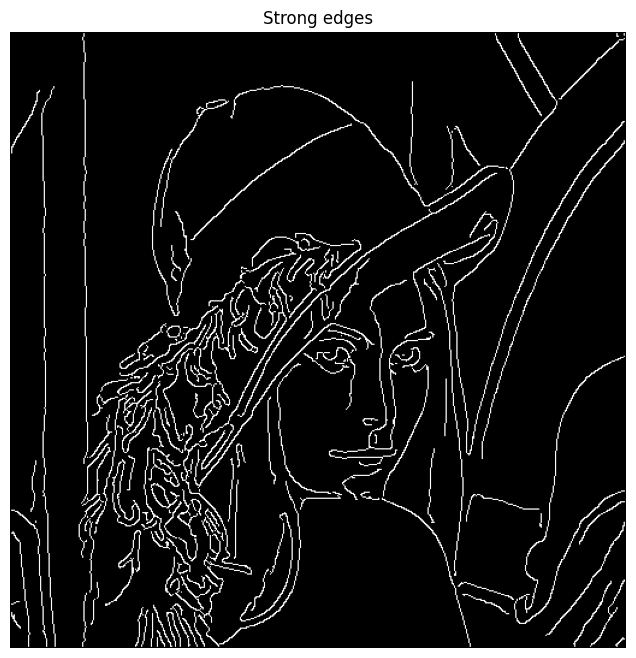

In [29]:
# display the final image
plt.figure(figsize=(12,8))
plt.imshow(strong_edges, 'gray')
plt.title('Strong edges')
plt.axis('off');

### Forming a Function from Previous Steps and Parameter Analysis

In [30]:
def canny_edge_detection(image_in, std, down_thresh, up_thresh):

    image_in = rgb_gray(image_in)

    gauss_image = gauss(image_in, std)                    # apply Gaussian filter

    gradient_x, gradient_y = gradients(gauss_image)       # determine gradients

    magnitude, theta = mag_thet(gradient_y, gradient_x)   # determine magnitude and angle

    theta = quant(theta)                                  # quantize angle
        
    magnitude = supression(magnitude, theta)              # suppress edges 
  

    strong_edges, weak_edges = strong_weak_edges(magnitude, up_thresh, down_thresh)   # determine strong and weak edges
    strong_edges, weak_edges = inclusion(strong_edges, weak_edges)                    # include weak edges

    return strong_edges

In [31]:
image = io.imread('lena_color.gif')

In [33]:
stds = [0.001, 0.5, 1, 2, 5, 8] # standard deviations
image_rgb = image[0]  # Extract the 3D RGB image from the 4D array
image_out1 = canny_edge_detection(image_rgb, stds[0], 10, 50)
image_out2 = canny_edge_detection(image_rgb, stds[1], 10, 50)
image_out3 = canny_edge_detection(image_rgb, stds[2], 10, 50)
image_out4 = canny_edge_detection(image_rgb, stds[3], 10, 50)
image_out5 = canny_edge_detection(image_rgb, stds[4], 10, 50)
image_out6 = canny_edge_detection(image_rgb, stds[5], 10, 50)

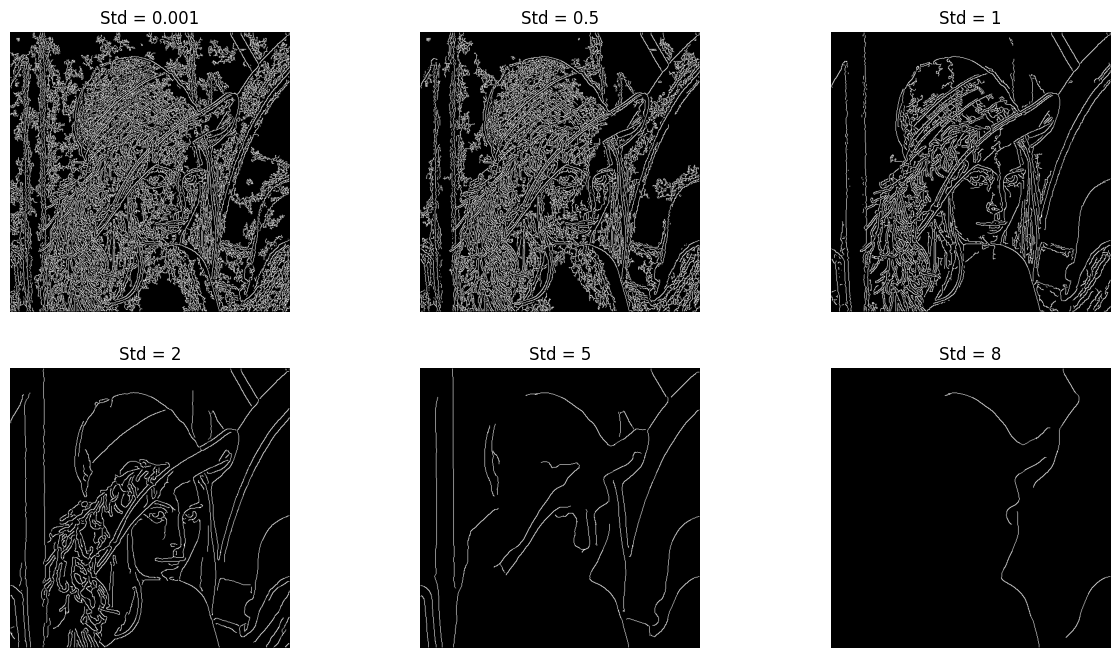

In [34]:
plt.figure(figsize=(15,8))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.imshow(eval('image_out'+str(i)), 'gray')
    plt.title('Std = '+str(stds[i-1]))
    plt.axis('off');

Increasing the standard deviation leads to greater blurring of the image, which results in detecting only the most evident contours and the inability to detect smaller transitions and edges from the original image.
For the best results obtained, a standard deviation of 2 was used.

Now, for a fixed standard deviation, the parameters of the upper threshold (the lower threshold is identical) are varied to determine strong edges.

In [36]:
up_threshs = [20, 30, 40, 50, 60, 70]    # upper thresholds
image_out7 = canny_edge_detection(image_rgb, 2, up_threshs[0], up_threshs[0])
image_out8 = canny_edge_detection(image_rgb, 2, up_threshs[1], up_threshs[1])
image_out9 = canny_edge_detection(image_rgb, 2, up_threshs[2], up_threshs[2])
image_out10 = canny_edge_detection(image_rgb, 2, up_threshs[3], up_threshs[3])
image_out11 = canny_edge_detection(image_rgb, 2, up_threshs[4], up_threshs[4])
image_out12 = canny_edge_detection(image_rgb, 2, up_threshs[5], up_threshs[5])

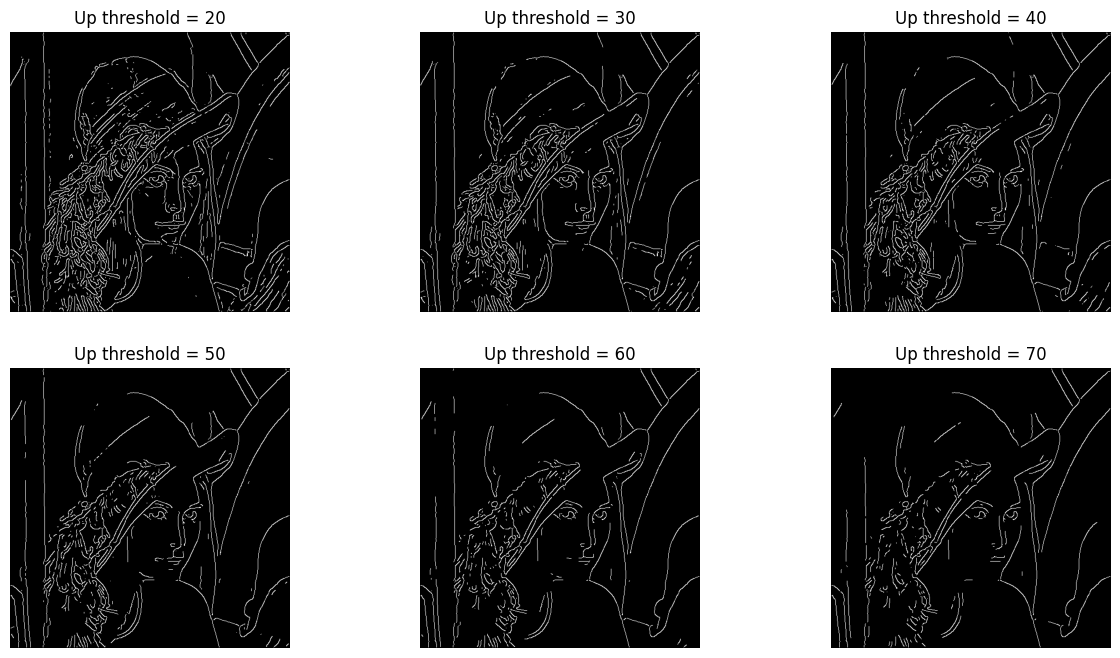

In [37]:
plt.figure(figsize=(15,8))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.imshow(eval('image_out'+str(6+i)), 'gray')
    plt.title('Up threshold = '+str(up_threshs[i-1]))
    plt.axis('off');

Analysis of the upper threshold that defines strong edges concludes that a value of 0.2 provides the optimal amount of extracted edges. Thresholds above do not detect enough edges, while lower values can sometimes capture a lot of noise.

Now, for a fixed standard deviation and upper threshold, the parameters of the lower threshold are varied to determine weak edges.

In [39]:
down_threshs = [2, 5, 10, 20, 30, 40]    # lower thresholds
image_rgb = image[0]  # Extract the 3D RGB image from the 4D array
image_out13 = canny_edge_detection(image_rgb, 2, down_threshs[0], 50)
image_out14 = canny_edge_detection(image_rgb, 2, down_threshs[1], 50)
image_out15 = canny_edge_detection(image_rgb, 2, down_threshs[2], 50)
image_out16 = canny_edge_detection(image_rgb, 2, down_threshs[3], 50)
image_out17 = canny_edge_detection(image_rgb, 2, down_threshs[4], 50)
image_out18 = canny_edge_detection(image_rgb, 2, down_threshs[5], 50)

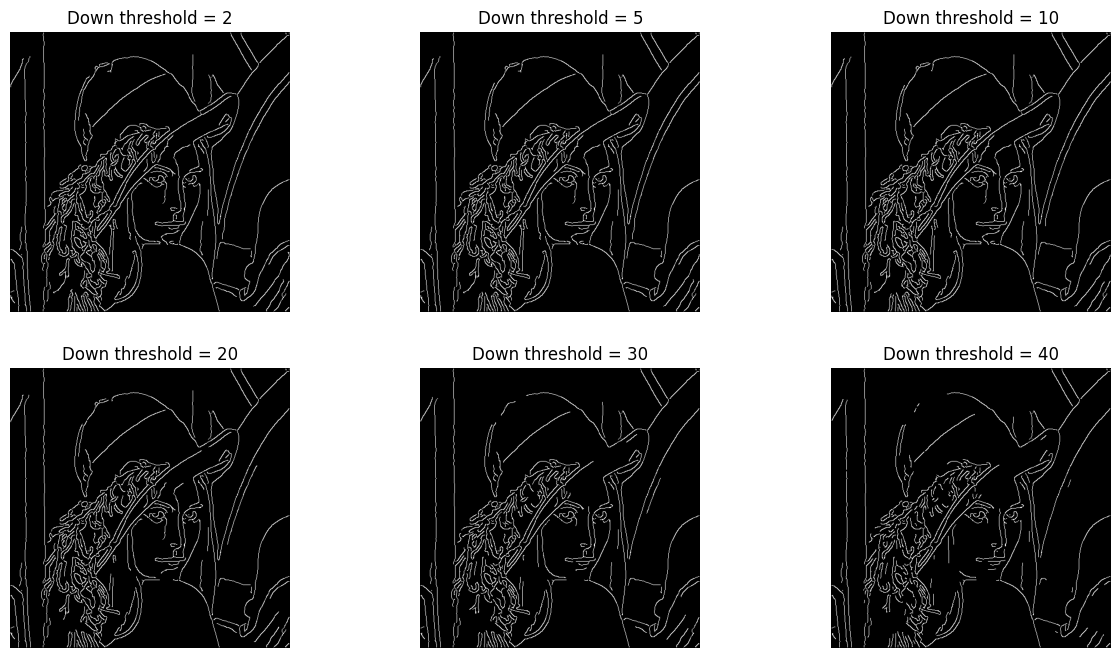

In [40]:
plt.figure(figsize=(15,8))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.imshow(eval('image_out'+str(12+i)), 'gray')
    plt.title('Down threshold = '+str(down_threshs[i-1]))
    plt.axis('off');

By analyzing the change in the lower threshold parameters, no significant differences are observed. Increasing it certainly reveals additional edge parts (more noticeable in other examples). The optimal value is taken as 0.125.

Comparison of edges obtained by applying the implemented and built-in method:

In [42]:
image_rgb = image[0]  # Extract the 3D RGB image from the 4D array
image_out13 = canny_edge_detection(image_rgb, 2, 10, 50)

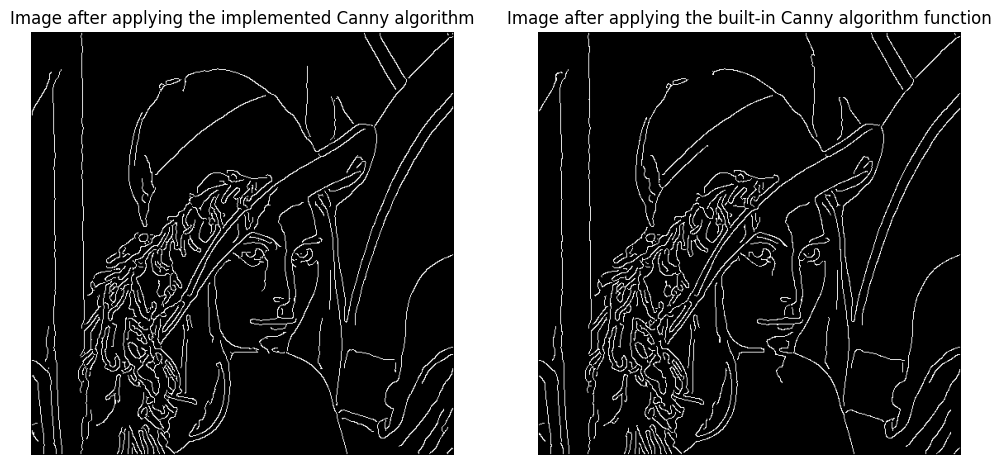

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(image_out13, 'gray')
plt.title('Image after applying the implemented Canny algorithm')
plt.axis('off');
plt.subplot(1, 2, 2)
image_rgb = image[0]  # Extract the 3D RGB image from the 4D array
canny_included = feature.canny(rgb_gray(image_rgb), sigma=2, low_threshold=10, high_threshold=50)
plt.imshow(canny_included, 'gray')
plt.title('Image after applying the built-in Canny algorithm function')
plt.axis('off');

When comparing the performance of the implemented and built-in Canny filter functions, no significant differences are observed. Some parts of the image are slightly sparser, which can be resolved by slightly increasing the upper threshold.

### Testing the function on other images

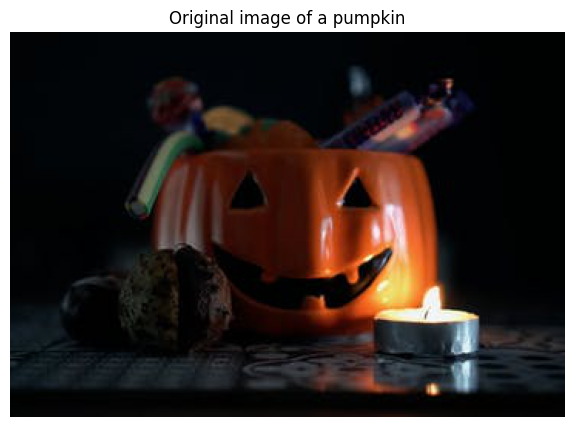

In [45]:
# loading images
image_bun = io.imread('test1.jpeg')
# displaying images
plt.figure(figsize=(12,5))
plt.imshow(image_bun, 'gray')
plt.title('Original image of a pumpkin')
plt.axis('off');

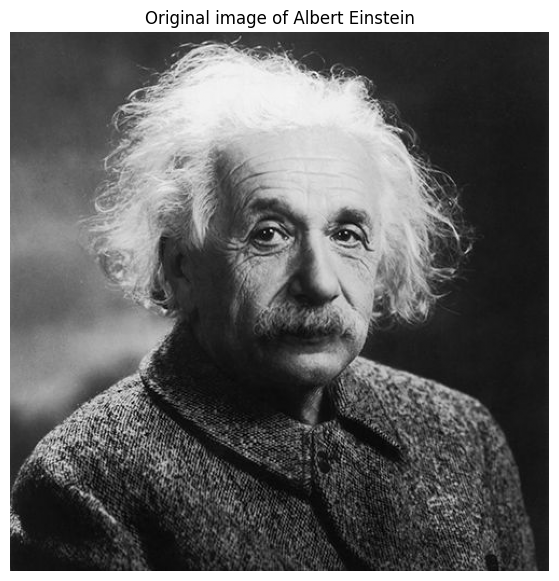

In [46]:
# loading images
image_einstein = io.imread('einstein.jpeg')
# displaying images
plt.figure(figsize=(12,7))
plt.imshow(image_einstein, 'gray')
plt.title('Original image of Albert Einstein')
plt.axis('off');

In [47]:
bun_canny = canny_edge_detection(image_bun, 2, 5, 30) # applying Canny algorithm to the pumpkin image

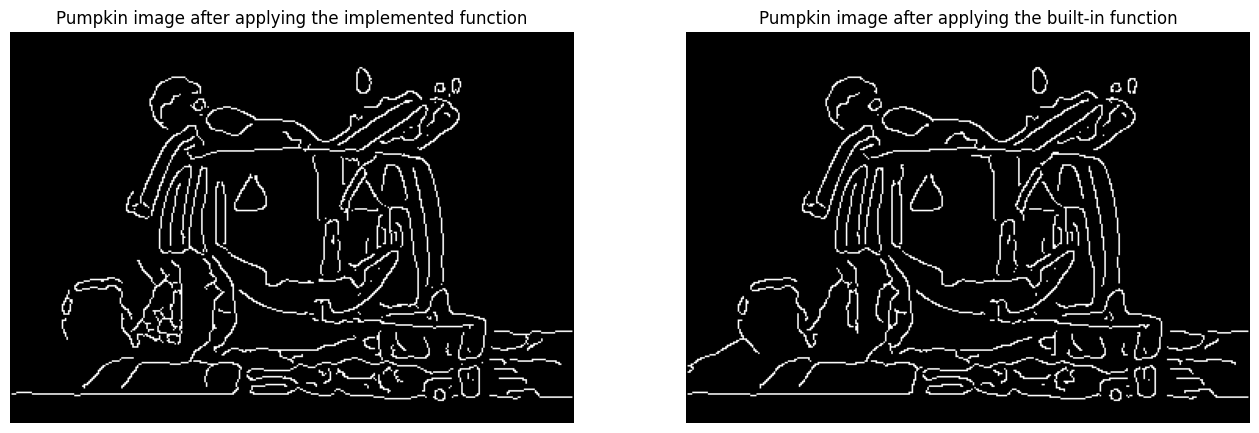

In [48]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(bun_canny, 'gray')
plt.title('Pumpkin image after applying the implemented function')
plt.axis('off');
plt.subplot(1, 2, 2)
canny_included = feature.canny(rgb_gray(image_bun), sigma=2, low_threshold=5, high_threshold=30)
plt.imshow(canny_included, 'gray')
plt.title('Pumpkin image after applying the built-in function')
plt.axis('off');

In [49]:
einstein_canny = canny_edge_detection(image_einstein, 2, 30, 50)    # applying Canny algorithm to the Einstein image

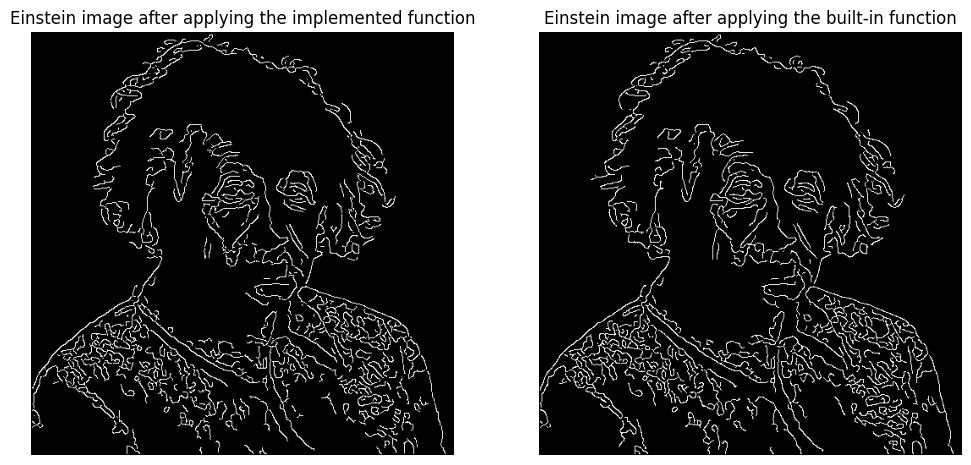

In [50]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(einstein_canny, 'gray')
plt.title('Einstein image after applying the implemented function')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(feature.canny(image_einstein, sigma=2), 'gray')
plt.title('Einstein image after applying the built-in function')
plt.axis('off');